# Automatic differentiation
We use automatic differentiation to compute the gradient automatically, saving us the trouble of writing the calculations by hand.

### Elves' execution (everything by hand)
![no graph](./images/no_graph.png)

Elves have a lot of time to waste, since they are basically immortal. If you are too, you are allowed to ignore automatic differentiation...

### The static computational graph (deferred execution)
![static graph](./images/static_graph.png)

The neuron gets compiled into a symbolic graph in which each node represents individual operations (second row), using placeholders for inputs and outputs

### The dynamic computational graph (immediate execution)
![dynamic graph](./images/dynamic_graph.png)

The computational graph is built node by node as the code is eagerly evaluated. It easier to accomplish conditional behavior, since the CG can change during successive forward passes.

## Autograd
Autograd is reverse automatic differentiation system. Conceptually, autograd records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

An important thing to note is that the graph is recreated from scratch at every iteration, and this is exactly what allows for using arbitrary Python control flow statements, that can change the overall shape and size of the graph at every iteration. You don’t have to encode all possible paths before you launch the training - what you run is what you differentiate.

NB: avoid in-place operations! They could raise errors

In [1]:
import torch
a = torch.tensor([[1., 2], [3, 4]], requires_grad=True)
b = torch.ones((2, 2), requires_grad=True)
a, b

(tensor([[1., 2.],
         [3., 4.]], requires_grad=True),
 tensor([[1., 1.],
         [1., 1.]], requires_grad=True))

In [2]:
c = a + b
d = b * c
d = d + a
d.retain_grad()
e = torch.mean(d) + torch.mean(b)

If there’s a single input to an operation that requires gradient, its output will also require gradient.

In [3]:
print(c.requires_grad)
print(d.requires_grad)
print(e.requires_grad)

True
True
True


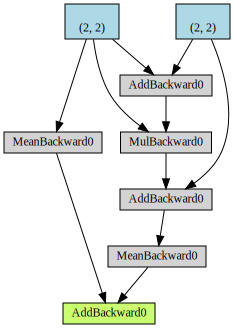

In [4]:
from torchviz import make_dot
make_dot(e)

In [5]:
print(b.grad)

None


In [6]:
e.backward()

In [7]:
print(b.grad)
print(a.grad) # they are leaves of the graph

tensor([[1.0000, 1.2500],
        [1.5000, 1.7500]])
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])


In [8]:
print(c.grad) # it is not a leaf

None


In [9]:
print(d.grad) # it is not a leaf, but has the attribute retains_grad=True

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [11]:
# e.backward() # error

For memory efficiency, the graph is deleted during the backward. If you want not the graph to be freed, specify retain_graph=True 

In [12]:
a.grad.zero_()
b.grad.zero_()
c = a + b
d = b * c
d = d + a
d.retain_grad()
e = torch.mean(d) + torch.mean(b)

for i in range(3):
    e.backward(retain_graph=True)

Calling backward leads derivatives to accumulate at leaf nodes. You need to zero the gradient explicitly after using it for parameter updates

In [13]:
print(b.grad)

tensor([[3.0000, 3.7500],
        [4.5000, 5.2500]])


In [14]:
# Dynamic graph - (define-by-run)
x = torch.tensor([1., 2.], requires_grad=True)
y = x.sum()

while y.data.norm() < 12:
    y = y * 1.2

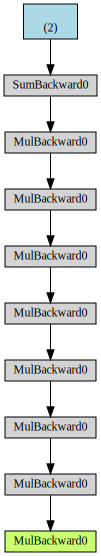

In [15]:
make_dot(y)

In [16]:
y.backward()

In [17]:
x.grad

tensor([4.2998, 4.2998])

In [19]:
# you cannot get a numpy array from a tensor which requires grad
# x.numpy() # error

# we must detach it from the computational graph
print(x)
print(x.detach())
print(x.detach().numpy())

tensor([1., 2.], requires_grad=True)
tensor([1., 2.])
[1. 2.]


In [20]:
# both detach() and numpy() are both views on the same storage
x_dn = x.detach().numpy()
x[0] = 99
print(x_dn)

[99.  2.]


## Resources
[Automatic differentiation in Pytorch](https://openreview.net/pdf?id=BJJsrmfCZ)

[Autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

[Nice overview on Pytorch (the pictures above are taken from here!)](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)